In [363]:
import torch
import numpy as np
from sklearn.datasets import fetch_california_housing
import pandas as pd

In [364]:
data = fetch_california_housing()
data.keys()
data, target, frame, target_names, feature_names, descr = data['data'], data['target'], data['frame'], data['target_names'], data['feature_names'], data['DESCR']

num_features = 8 
df = pd.DataFrame(data, columns=feature_names)
df[target_names[0]]  = target
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [365]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
for feature in feature_names:
    scaler.fit(df[[ feature ]])
    df[feature] = scaler.transform(df[[ feature ]])

df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,2.064000e+04,2.064000e+04,2.064000e+04,2.064000e+04,2.064000e+04,20640.000000,2.064000e+04,2.064000e+04,20640.000000
mean,5.508083e-17,4.406467e-17,7.711317e-17,-1.005225e-16,-1.101617e-17,0.000000,2.247298e-15,-8.603626e-15,2.068558
std,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024,1.000024e+00,1.000024e+00,1.153956
min,-1.774299e+00,-2.196180e+00,-1.852319e+00,-1.610768e+00,-1.256123e+00,-0.229000,-1.447568e+00,-2.385992e+00,0.149990
25%,-6.881186e-01,-8.453931e-01,-3.994496e-01,-1.911716e-01,-5.638089e-01,-0.061711,-7.967887e-01,-1.113209e+00,1.196000
50%,-1.767951e-01,2.864572e-02,-8.078489e-02,-1.010650e-01,-2.291318e-01,-0.024316,-6.422871e-01,5.389137e-01,1.797000
75%,4.593063e-01,6.643103e-01,2.519615e-01,6.015869e-03,2.644949e-01,0.020375,9.729566e-01,7.784964e-01,2.647250
max,5.858286e+00,1.856182e+00,5.516324e+01,6.957171e+01,3.025033e+01,119.419103,2.958068e+00,2.625280e+00,5.000010


In [366]:
X_train, X_test, Y_train, Y_test = train_test_split(df[feature_names], df[target_names])
X = torch.tensor(X_train.values, dtype=torch.float64)
Y = torch.tensor(df[target_names].values, dtype=torch.float64)

alpha = 0.0001
print(X.shape, X.dtype, Y, Y.dtype, sep=" ")

torch.Size([15480, 8]) torch.float64 tensor([[4.5260],
        [3.5850],
        [3.5210],
        ...,
        [0.9230],
        [0.8470],
        [0.8940]], dtype=torch.float64) torch.float64


In [367]:
weights, bias = torch.randn(num_features, 1, requires_grad=True, dtype=torch.float64), torch.randn(1, requires_grad=True, dtype=torch.float64)
X.shape, Y.shape, weights.shape, bias.shape, weights.dtype, bias.dtype, X.dtype, Y.dtype

(torch.Size([15480, 8]),
 torch.Size([20640, 1]),
 torch.Size([8, 1]),
 torch.Size([1]),
 torch.float64,
 torch.float64,
 torch.float64,
 torch.float64)

In [368]:
from torch.utils.data.dataloader import DataLoader, Dataset

class CustomData(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return (self.data[index], self.labels[index])

dataset = CustomData(X, Y)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [369]:
def forward(w, x, b):
    return torch.matmul(x, w) + b

def loss(pred, labels):
    return torch.mean((pred - labels) ** 2) 

losses = []
for _ in range(1000):
    for batch, (X, Y) in enumerate(dataloader):
        pred = forward(weights, X, bias)
        l = loss(pred, Y)
        l.backward()

        with torch.no_grad():
            weights.data -= weights.grad.data * alpha
            bias.data -= bias.grad.data * alpha

        weights.grad.zero_()
        bias.grad.zero_()
        losses.append(l.item())

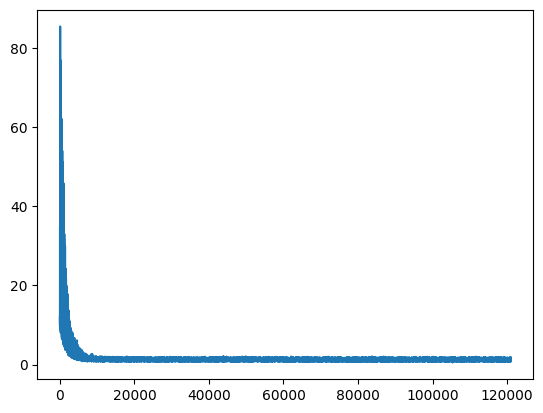

In [370]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

In [371]:
def inference(w, x, b):
    with torch.no_grad():
        return torch.matmul(x, w) + b

test_predictions = inference(weights, torch.tensor( X_test.values ), bias)

loss(test_predictions, torch.tensor(Y_test.values))

tensor(1.3760, dtype=torch.float64)